In [1]:
import pandas as pd
import sqlite3
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

### calculate distances from different sources

In [2]:
def load_sqlite_database(sql_path):
    """
    Load metadata and connectivity data from SQLite database.
    """
    conn = sqlite3.connect(sql_path)
    meta_df = pd.read_sql_query("SELECT * FROM meta", conn)
    try:
        edgelist_df = pd.read_sql_query("SELECT * FROM edgelist_simple", conn)
    except Exception:
        edgelist_df = pd.read_sql_query("SELECT * FROM edgelist", conn)
    conn.close()
    return meta_df, edgelist_df

def filter_by_cell_type(example_df: pd.DataFrame, 
                        meta_df: pd.DataFrame, 
                        cell_type_column: str, 
                        id_column: str, 
                        search_str: str) -> pd.DataFrame:
    """
    Filters rows from example_df where the cell_type in meta_df contains the given search_str.

    Parameters:
        example_df (pd.DataFrame): DataFrame with neuron data containing the 'id' column.
        meta_df (pd.DataFrame): DataFrame containing 'id' and cell_type information.
        cell_type_column (str): The column name in meta_df that contains cell type labels.
        id_column (str): The column name in both DataFrames that identifies neurons.
        search_str (str): Substring to search for in the cell_type column.

    Returns:
        pd.DataFrame: Filtered rows of example_df where the cell type contains search_str.
    """
    # Ensure the id column in both DataFrames is of the same type
    example_df[id_column] = example_df[id_column].astype(str)
    meta_df[id_column] = meta_df[id_column].astype(str)

    # Merge example_df with meta_df to include cell_type info
    merged_df = example_df.merge(meta_df[[id_column, cell_type_column]], on=id_column, how='left')

    # Filter rows where cell_type contains the search_str
    filtered_df = merged_df[merged_df[cell_type_column].str.contains(search_str, case=False, na=False)]

    # Return only the original columns of example_df
    return filtered_df#[example_df.columns]

def calculate_avg_std(filtered_df: pd.DataFrame) -> dict:
    """
    Calculates the average and standard deviation for relevant columns in the filtered DataFrame.
    Organizes the results into a nested dictionary where:
      - Outer dict key: Neuron seed name (extracted before 'influence')
      - Inner dict key: The part of the column name after 'influence' and before 'forward'
      - Value: Tuple of (mean, std) and (log mean, log std)

    Parameters:
        filtered_df (pd.DataFrame): Filtered DataFrame returned from `filter_by_cell_type`.

    Returns:
        dict: Nested dictionary of mean and std (including log) organized by neuron seed name and column parts.
    """
    results = {}

    for col in filtered_df.columns:
        if 'influence' in col and 'matrix_index' not in col and 'id' not in col:
            # Extract parts of the column name
            parts = col.split('_')
            seed_name = '_'.join(parts[:parts.index('influence')])
            inner_key = '_'.join(parts[parts.index('influence') + 1:parts.index('forward')])

            # Calculate mean and std
            mean = filtered_df[col].mean()
            std = filtered_df[col].std()

            # Calculate log mean and std, avoiding negative or zero values
            log_data = np.log(filtered_df[col][filtered_df[col] > 0])
            log_mean = log_data.mean() if not log_data.empty else None
            log_std = log_data.std() if not log_data.empty else None

            # Organize into nested dictionary
            if seed_name not in results:
                results[seed_name] = {}
            results[seed_name][inner_key] = {
                "mean_std": (mean, std),
                "log_mean_std": (log_mean, log_std)
            }

    return results

def organize_dis(filtered_df: pd.DataFrame) -> dict:
    """
    Calculates the average and standard deviation for relevant columns in the filtered DataFrame.
    Organizes the results into a nested dictionary where:
      - Outer dict key: Neuron seed name (extracted before 'influence')
      - Inner dict key: The part of the column name after 'influence' and before 'forward'
      - Value: Tuple of (mean, std) and (log mean, log std)

    Parameters:
        filtered_df (pd.DataFrame): Filtered DataFrame returned from `filter_by_cell_type`.

    Returns:
        dict: Nested dictionary of distances organized by neuron seed name and column parts.
    """
    results = {}

    for col in filtered_df.columns:
        if 'influence' in col and 'matrix_index' not in col and 'id' not in col:
            # Extract parts of the column name
            parts = col.split('_')
            seed_name = '_'.join(parts[:parts.index('influence')])
            inner_key = '_'.join(parts[parts.index('influence') + 1:parts.index('forward')])

            # Organize into nested dictionary
            if seed_name not in results:
                results[seed_name] = {}
            results[seed_name][inner_key] = filtered_df[col].values

    return results


def organize_dis2(filtered_df: pd.DataFrame, file_path: str) -> dict:
    """
    Records distances from a filtered DataFrame and organizes them into a dictionary
    using the seed name extracted from the pickle file name.

    Parameters:
        filtered_df (pd.DataFrame): Filtered DataFrame containing a single column named 'distance'.
        file_path (str): Path to the pickle file, used to extract the seed name.

    Returns:
        dict: Dictionary with the seed name as the key and the distances (list) as the value.
    """
    # Extract the seed name from the file path
    file_name = os.path.basename(file_path)
    seed_name = file_name.split('_to_all')[0]
    
    # Record the distances
    distances = filtered_df['distance'].tolist()
    
    # Organize into dictionary
    return {seed_name: distances}


def get_csv_files_from_directory(directory: str) -> list:
    """
    Retrieves all CSV file paths from a specified directory.

    Parameters:
        directory (str): Path to the directory containing CSV files.

    Returns:
        list: List of file paths to CSV files.
    """
    csv_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]
    return csv_files

def get_pkl_files_from_directory(directory: str) -> list:
    """
    Retrieves all pickle (.pkl) file paths from a specified directory.

    Parameters:
        directory (str): Path to the directory containing pickle files.

    Returns:
        list: List of file paths to pickle files.
    """
    pkl_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.pkl')]
    return pkl_files


def process_and_save_results(example_files: list, meta_df: pd.DataFrame, output_pkl_raw: str, output_json_summary: str, 
                             cell_type_column: str, id_column: str, search_str: str):
    """
    Processes multiple example CSV files, calculates averages and std deviations, and saves results to a JSON file.

    Parameters:
        example_files (list): List of file paths to example CSV files.
        meta_df (pd.DataFrame): metadata.
        output_json (str): Path to save the combined JSON results.
        cell_type_column (str): The column name in meta_df for cell type labels.
        id_column (str): The shared column for IDs in the DataFrames.
        search_str (str): Substring to search for in cell_type labels.
    """
    #meta_df = pd.read_csv(meta_file)
    summary_results = []
    raw_results = []

    for file in example_files:
        example_df = pd.read_csv(file)
        filtered_df = filter_by_cell_type(example_df, meta_df, cell_type_column, id_column, search_str)
        summary_result = calculate_avg_std(filtered_df)
        raw_result = organize_dis(filtered_df)
        summary_results.append(summary_result)
        raw_results.append(raw_result)

    # Save results to a JSON file
    with open(output_json_summary, 'w') as json_file:
        json.dump(summary_results, json_file, indent=4)
    with open(output_pkl_raw, 'wb') as pkl_file:
        pickle.dump(raw_results, pkl_file)

    print(f"Results saved to {output_json_summary}")
    print(f"Results saved to {output_pkl_raw}")

def process_and_save_results2(example_files: list, meta_df: pd.DataFrame, output_pkl_raw: str,  
                             cell_type_column: str, id_column: str, search_str: str):
    """
    Processes multiple example pickle (.pkl) files, calculates averages and standard deviations, 
    and saves results to a JSON file and raw data to a pickle file.

    Parameters:
        example_files (list): List of file paths to example pickle files.
        meta_df (pd.DataFrame): Metadata as a DataFrame.
        output_pkl_raw (str): Path to save the combined raw pickle results.
        output_json_summary (str): Path to save the combined JSON summary results.
        cell_type_column (str): The column name in meta_df for cell type labels.
        id_column (str): The shared column for IDs in the DataFrames.
        search_str (str): Substring to search for in cell type labels.
    """
    #summary_results = []
    raw_results = []

    for file in example_files:
        # Read pickle file into a DataFrame
        example_df = pd.read_pickle(file)
        
        # Filter data based on metadata
        filtered_df = filter_by_cell_type(example_df, meta_df, cell_type_column, id_column, search_str)
        #print(filtered_df)
        #break
        
        # Compute summary statistics
        #summary_result = calculate_avg_std(filtered_df)
        raw_result = organize_dis2(filtered_df,file)
        
        # Append results
        #summary_results.append(summary_result)
        raw_results.append(raw_result)
    
    # Save raw results to a pickle file
    with open(output_pkl_raw, 'wb') as pkl_file:
        pickle.dump(raw_results, pkl_file)

    #print(f"Results saved to {output_json_summary}")
    print(f"Results saved to {output_pkl_raw}")


In [3]:
sql_path = "/n/data1/hms/neurobio/wilson/banc/connectivity/frankenbrain_v.1.1_data.sqlite"
meta_df, edgelist_df = load_sqlite_database(sql_path)

In [4]:
meta_df.modality.unique()

array(['olfactory', '', 'mechanosensory', 'endocrine', 'motor',
       'unknown_sensory', 'hygrosensory', 'thermosensory', 'gustatory',
       'visual', 'proprioceptive', 'proprioceptive_tactile', 'unknown',
       'mixed', 'proprioceptive_unknown', 'tactile', 'tactile_unknown',
       'chemosensory_unknown', 'chemosensory_proprioceptive',
       'chemosensory', 'chemosensory_tactile'], dtype=object)

In [64]:
directory_path = '/n/groups/wilson/Jingxuan/BANC-project/data/cascade/frankenbrain_v1.1/seeds/signed'
output_pkl_raw = '/n/groups/wilson/Jingxuan/BANC-project/python/MB_analysis/results/cascade_seeds_PAM_raw.pkl'
json_path_summary = '/n/groups/wilson/Jingxuan/BANC-project/python/MB_analysis/results/cascade_seeds_PAM_summary.json'
pkl_list = get_pkl_files_from_directory(directory_path)

In [65]:
process_and_save_results2(pkl_list, meta_df, output_pkl_raw, 'cell_type', 'id', 'PAM')

Results saved to /n/groups/wilson/Jingxuan/BANC-project/python/MB_analysis/results/cascade_seeds_PAM_raw.pkl


In [30]:
def plot_log_mean_std(json_file: str, dis_metric: str):
    """
    Plots the log mean and log standard deviation for 'count_unsigned' across all keys in the JSON file.

    Parameters:
        json_file (str): Path to the JSON file containing the nested dictionary results.
    """
    with open(json_file, 'r') as f:
        data = json.load(f)

    keys = []
    log_means = []
    log_stds = []

    for item in data:
        outer_key = list(item.keys())[0]
        inner_dict = item[outer_key]
        if dis_metric in inner_dict:
            log_mean, log_std = inner_dict[dis_metric].get("log_mean_std", (None, None))
            if log_mean is not None and log_std is not None:
                keys.append(outer_key)
                log_means.append(log_mean)
                log_stds.append(log_std)

    # Dynamically adjust figure size based on number of keys
    fig_height = max(6, len(keys) * 0.5)
    plt.figure(figsize=(10, fig_height))
    plt.barh(keys, log_means, xerr=log_stds, capsize=5)
    #plt.xlabel('Log Mean with Std Error')
    #plt.ylabel('Keys')
    #plt.title('Log Mean and Std of count_unsigned')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [68]:
def plot_count_unsigned(pkl_file: str, dis_metric: str):
    """
    Function to plot the count_unsigned field from a pickle file containing dictionaries.

    Args:
        file_path (str): Path to the pickle file.
    """
    # Load the pickle file
    with open(pkl_file, 'rb') as file:
        data = pickle.load(file)
    # Customize the plot
    fig_height = max(6, len(data) * 0.5)
    plt.figure(figsize=(10, fig_height))
    y_ticks = []  # Store y-axis tick positions
    y_labels = []  # Store corresponding labels
    for idx, item in enumerate(data):
        outer_key = list(item.keys())[0]
        inner_dict = item[outer_key]

        # Extract the count_unsigned field
        count_unsigned = inner_dict.get(dis_metric)

        if count_unsigned is not None and isinstance(count_unsigned, np.ndarray):
            # Scatter plot the count_unsigned data on log scale
            x = count_unsigned
            y = np.full_like(x, idx, dtype=float)  # Stack keys on the y-axis
            plt.scatter(x, y, color='blue', alpha=0.6, label=outer_key if idx < 10 else None)  # Limit legend entries

            # Plot a horizontal line for the mean
            mean_value = np.mean(x)
            plt.plot([mean_value, mean_value], [idx - 0.4, idx + 0.4], color='black', linestyle='--', linewidth=0.8, alpha=0.7)
            # Collect y-axis ticks and labels
            y_ticks.append(idx)
            y_labels.append(outer_key)
    # Set y-axis ticks and labels
    plt.yticks(y_ticks, y_labels, fontsize=8)
    plt.xscale('log')
    #plt.xlabel('Count Unsigned (log scale)')
    #plt.ylabel('Dictionary Keys')
    #plt.title('Scatter Plot of count_unsigned with Mean Lines')
    #plt.legend(loc='upper right', title='Keys (First 10)', fontsize='small', ncol=1)
    plt.grid(alpha=0.3, which="both")
    plt.xlim(1e-10,1)
    plt.tight_layout()

    # Show the plot
    plt.show()



def plot_cascade(pkl_file: str):
    """
    Function to plot the distance field from a pickle file containing dictionaries.

    Args:
        file_path (str): Path to the pickle file.
    """
    # Load the pickle file
    with open(pkl_file, 'rb') as file:
        data = pickle.load(file)
    # Customize the plot
    fig_height = max(6, len(data) * 0.5)
    plt.figure(figsize=(10, fig_height))
    y_ticks = []  # Store y-axis tick positions
    y_labels = []  # Store corresponding labels
    for idx, item in enumerate(data):
        #outer_key = list(item.keys())[0]
        #inner_dict = item[outer_key]

        # Extract the count_unsigned field
        #count_unsigned = inner_dict.get(dis_metric)
        key = list(item.keys())[0]
        value = np.array(item[key])
        #print(value)

        if value is not None and isinstance(value, np.ndarray):
            # Scatter plot the count_unsigned data on log scale
            x = value
            y = np.full_like(x, idx, dtype=float)  # Stack keys on the y-axis
            jitter = np.random.uniform(-0.1, 0.1, size=len(y))  # Add jitter to y-axis
            jittered_y = y + jitter
            #jittered_y = [idx + random.uniform(-0.1, 0.1) for _ in time_steps]  # Add jitter to y-axis
            plt.scatter(x, jittered_y, color='red', alpha=0.6, label=key if idx < 10 else None)  # Limit legend entries

            # Plot a horizontal line for the mean
            mean_value = np.mean(x)
            plt.plot([mean_value, mean_value], [idx - 0.4, idx + 0.4], color='black', linestyle='--', linewidth=0.8, alpha=0.7)
            # Collect y-axis ticks and labels
            y_ticks.append(idx)
            y_labels.append(key)
    # Set y-axis ticks and labels
    plt.yticks(y_ticks, y_labels, fontsize=8)
    #plt.xscale('log')
    #plt.xlabel('Count Unsigned (log scale)')
    #plt.ylabel('Dictionary Keys')
    #plt.title('Scatter Plot of count_unsigned with Mean Lines')
    #plt.legend(loc='upper right', title='Keys (First 10)', fontsize='small', ncol=1)
    plt.grid(alpha=0.3, which="both")
    #plt.xlim(1e-10,1)
    plt.tight_layout()

    # Show the plot
    plt.show()



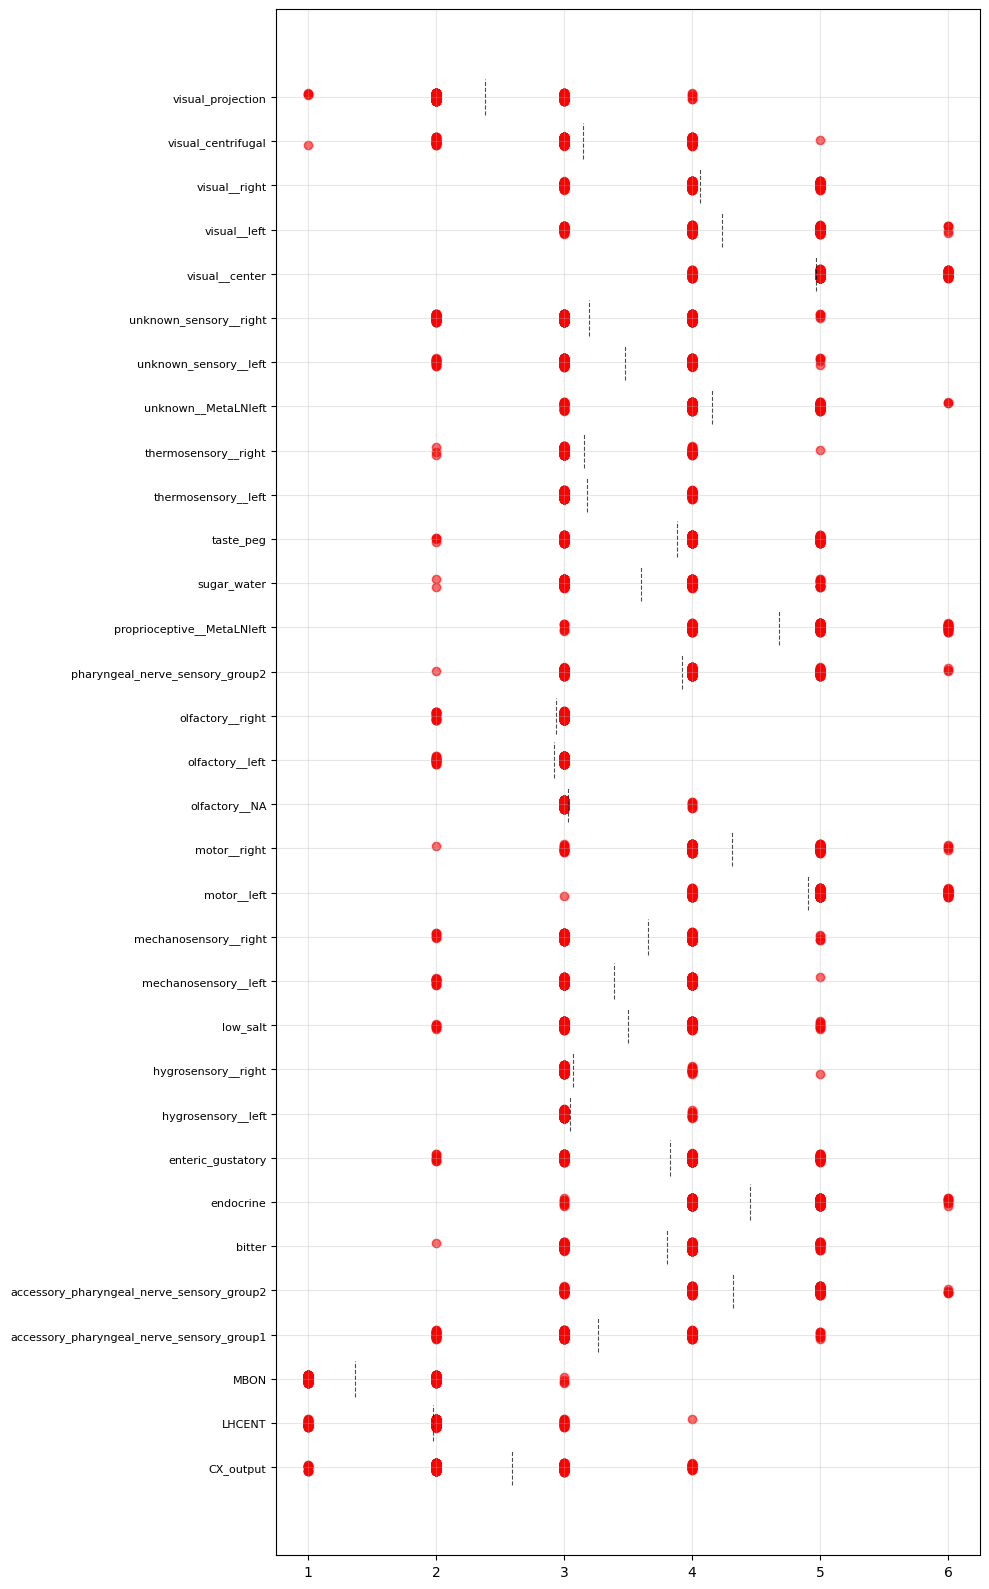

In [69]:
# Example usage
# Replace 'your_file.pkl' with the path to your pickle file
output_pkl_raw = '/n/groups/wilson/Jingxuan/BANC-project/python/MB_analysis/results/cascade_seeds_PAM_raw.pkl'
plot_cascade(output_pkl_raw)
